In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
from util import RND, compute_fitting_loss

In [3]:
torch.__version__

'2.0.0'

In [4]:
# !wget https://github.com/qmfin/option_data/raw/main/sp500_2017.json.bz2

In [5]:
option_data = pd.read_json('./sp500_2017.json.bz2', compression='bz2', orient='index')

In [6]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
torch.set_default_tensor_type(torch.cuda.FloatTensor if is_cuda else torch.FloatTensor)

In [7]:
date = '2017-01-03'
time_to_maturity = 8

In [8]:
subset = option_data.query('date=="%s" and time_to_maturity==%d'%(date,time_to_maturity)).copy()

In [9]:
subset_train = subset.loc[::2]
subset_test = subset.loc[1::2]

In [10]:
# hyper_parameters
n_layers = 4
n_samples = 5000
n_models = 8
learning_rate = 0.01
max_iter = 2000
mae_ratio, mape_ratio, mse_ratio, cond_mean_ratio = 0.1, 1.0, 0.1, 100.0

In [11]:
# configs
print_freq = 100
num_ni = 10000 # number of intervals for numerical integration
eval_bound_mul = 1.25
eval_num_mul = 10

In [12]:
monf = RND(n_models, n_layers, device)

In [13]:
opt = torch.optim.Adam(monf.parameters(), lr=learning_rate, amsgrad=True)

In [14]:
for _ in range(max_iter):

    opt.zero_grad()
    
    cond_mean = monf.mc_pricing(n_samples, 0.0, 1.0)[0]
    cond_mean_loss = torch.abs(cond_mean-1.0)
    rescaler = float((1.0/(cond_mean.detach())).cpu().numpy())
    
    strike_price_normalized = torch.from_numpy((subset_train['strike_price']/subset_train['forward_price']).values).to(device)
    option_price_normalized = torch.from_numpy((subset_train['option_price']/subset_train['forward_price']*np.exp(subset_train['tau']*subset_train['risk_free_rate'])).values).to(device)
    is_call = torch.from_numpy((subset_train['is_call']).values).to(device)
    
    price_est_train = monf.mc_pricing(n_samples, strike_price_normalized, is_call, rescaler)
    price_est_train_re = price_est_train.detach().cpu().numpy()*(subset_train['forward_price']/np.exp(subset_train['tau']*subset_train['risk_free_rate'])).values
    ae, ape, se = compute_fitting_loss(price_est_train, option_price_normalized)
    mae, mape, mse = ae.mean(), ape.mean(), se.mean()
    
    loss = mae_ratio*mae + mape_ratio*mape + mse_ratio*mse + cond_mean_ratio*cond_mean_loss
    loss.backward()
    opt.step()
    

    if _ % print_freq == 0:
        strike_price_normalized = torch.from_numpy((subset_test['strike_price']/subset_test['forward_price']).values).to(device)
        option_price_normalized = torch.from_numpy((subset_test['option_price']/subset_test['forward_price']*np.exp(subset_test['tau']*subset_test['risk_free_rate'])).values).to(device)
        is_call = torch.from_numpy((subset_test['is_call']).values).to(device)        
        _k_min = monf.samples_buff.min().detach().cpu().numpy()*eval_bound_mul
        _k_max = monf.samples_buff.max().detach().cpu().numpy()*eval_bound_mul
        price_est_test = monf.ni_pricing(_k_min, _k_max, num_ni, strike_price_normalized, is_call, rescaler)
        price_est_test_re = price_est_test.detach().cpu().numpy()*(subset_test['forward_price']/np.exp(subset_test['tau']*subset_test['risk_free_rate'])).values
        ae, ape, se = compute_fitting_loss(price_est_test, option_price_normalized)
        mae, mape, mse = ae.mean(), ape.mean(), se.mean()
        print('ITER: %06d, MAE: %f, MAPE: %f, MSE: %f, MEAN: %f, RE: %f' % 
              (_, mae.detach().cpu().numpy(), mape.detach().cpu().numpy(), mse.detach().cpu().numpy(), 
               cond_mean.detach().cpu().numpy(), rescaler))

ITER: 000000, MAE: 0.036586, MAPE: 144.955412, MSE: 0.001453, MEAN: 1.017271, RE: 0.983022
ITER: 000100, MAE: 0.002345, MAPE: 0.777788, MSE: 0.000013, MEAN: 0.983691, RE: 1.016579
ITER: 000200, MAE: 0.000310, MAPE: 0.320221, MSE: 0.000000, MEAN: 1.000970, RE: 0.999031
ITER: 000300, MAE: 0.000506, MAPE: 0.287275, MSE: 0.000001, MEAN: 0.999680, RE: 1.000320
ITER: 000400, MAE: 0.000468, MAPE: 0.222492, MSE: 0.000001, MEAN: 0.999263, RE: 1.000738
ITER: 000500, MAE: 0.000178, MAPE: 0.169302, MSE: 0.000000, MEAN: 1.001385, RE: 0.998617
ITER: 000600, MAE: 0.000771, MAPE: 0.166817, MSE: 0.000002, MEAN: 0.999736, RE: 1.000264
ITER: 000700, MAE: 0.000378, MAPE: 0.121629, MSE: 0.000000, MEAN: 0.998224, RE: 1.001779
ITER: 000800, MAE: 0.000304, MAPE: 0.104520, MSE: 0.000000, MEAN: 0.999573, RE: 1.000428
ITER: 000900, MAE: 0.000337, MAPE: 0.097217, MSE: 0.000000, MEAN: 0.998549, RE: 1.001453
ITER: 001000, MAE: 0.000185, MAPE: 0.095624, MSE: 0.000000, MEAN: 0.998033, RE: 1.001971
ITER: 001100, MAE: 

In [15]:
subset.loc[::2,'option_price_est'] = price_est_train_re
subset.loc[1::2,'option_price_est'] = price_est_test_re

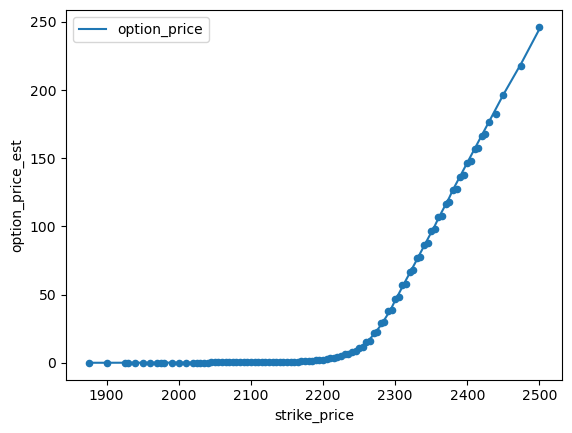

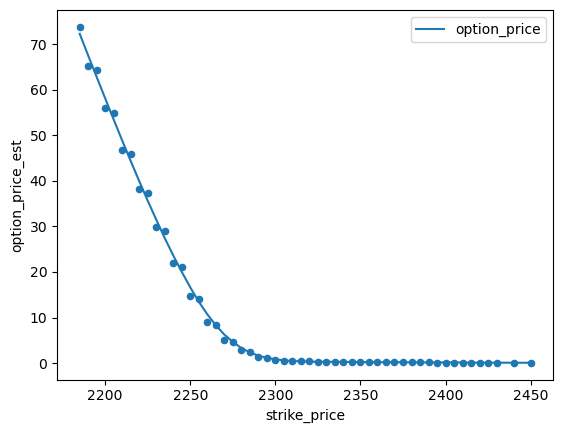

In [16]:
for _, v in subset.groupby('is_call'):
    ax=v.plot(x='strike_price', y='option_price', kind='line')
    v.plot(x='strike_price', y='option_price_est', kind='scatter',ax=ax)